In [1]:
!pip install numpy pandas matplotlib scipy yfinance arch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model
import yfinance as yf 
import time

In [2]:
# Black-Scholes functions

def bs_call(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_value = S0*norm.cdf(d1) - K*np.exp(-r * T)*norm.cdf(d2)
    return call_value

def bs_put(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    put_value = K*np.exp(-r * T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    return put_value

In [3]:
def bs_call_delta(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    return norm.cdf(d1)

The fit_garch_volatility function estimates the long-run volatility ($\sigma_{LR}$) from a time series of returns. This value is used as the Implied Volatility ($\sigma$) input for the Black-Scholes pricing model. The unconditional long-run variance ($\sigma^2_{LR}$) of a stationary GARCH(1,1) process is given by:$$\sigma^2_{LR} = \frac{\omega}{1 - \alpha - \beta}$$

In [4]:
# GARCH(1,1) Fitting Function

def fit_garch_volatility(returns_series):
    
    # Scale returns by 100 for better GARCH convergence
    am = arch_model(
        100 * returns_series.dropna(), 
        vol='Garch', 
        p=1, 
        q=1, 
        mean='Zero',
        dist='t'
    )
    
    try:
        res = am.fit(disp='off', last_obs=returns_series.index[-1])
        
        # Long-run variance = omega / (1 - alpha - beta)
        omega = res.params['omega']
        alpha = res.params['alpha[1]']
        beta = res.params['beta[1]']
        long_run_daily_var = omega / (1 - alpha - beta)
        
        # Annualized long-run standard deviation
        annualized_long_run_vol = np.sqrt(long_run_daily_var) * np.sqrt(252) / 100 
        
    except Exception as e:
        print(f"GARCH fitting failed (Error: {e}). Falling back to simple historical std.")
        # Fallback to simple historical volatility
        annualized_long_run_vol = returns_series.std() * np.sqrt(252)
    
    return annualized_long_run_vol

In [6]:
# Data Loading and Volatility Estimation with GARCH

def load_and_prep_data_with_garch(index_names, start_date, end_date):
    
    # Define tickers for common US indices
    tickers_map = {'IndexA': '^GSPC', 'IndexB': '^IXIC', 'IndexC': '^RUT'}
    ticker_list = [tickers_map[name] for name in index_names]
    
    # Download data
    try:
        all_data = yf.download(ticker_list, start=start_date, end=end_date)
        prices_df = all_data.xs('Close', axis=1, level=0, drop_level=True)
        prices_df.columns = index_names 
        
    except Exception as e:
        print(f"Error during yfinance download/extraction: {e}. Falling back to dummy data.")
        
        n_days = 253
        dates = pd.date_range(start=start_date, periods=n_days, freq='D')
        
        np.random.seed(42)
        dummy_prices = {}
        starts = {'IndexA': 400.0, 'IndexB': 250.0, 'IndexC': 180.0}
        daily_returns = np.random.normal(loc=0.0005, scale=0.01, size=(n_days - 1, len(index_names)))
        
        for i, name in enumerate(index_names):
            prices = starts[name] * np.exp(np.cumsum(daily_returns[:, i]))
            prices = np.insert(prices, 0, starts[name])
            dummy_prices[name] = prices
            
        prices_df = pd.DataFrame(dummy_prices, index=dates)
        
    prices_df = prices_df.dropna()
    log_returns_df = np.log(prices_df / prices_df.shift(1)).dropna()
    
    vols = {}

    # GARCH FITTING LOOP
    print("Fitting GARCH(1,1) models to index returns...")
    for name in index_names:
        returns = log_returns_df[name]
        long_run_vol = fit_garch_volatility(returns)
        vols[name] = long_run_vol 
        print(f"  {name} GARCH Long-Run Vol: {long_run_vol:.4f}")

    prices_arrays = [prices_df[name].values for name in index_names]
    n_steps = log_returns_df.shape[0]

    return prices_arrays, vols, n_steps

# User-configurable parameters

np.random.seed(42)
start_time = time.time()

index_names = ['IndexA', 'IndexB', 'IndexC']
start_date = '2023-01-01'
end_date = '2023-12-31' # E.g., one year of data

# Data Loading and Prep
prices_arrays, vol_proxies, n_steps = load_and_prep_data_with_garch(index_names, start_date, end_date)
n_paths = 1 

r = 0.02
maturity_days = n_steps
print(f"Simulation run over N_STEPS = {n_steps} days.")

weights = np.array([0.5, 0.3, 0.2])
initial_portfolio_value = 1_000_000
index_notional = initial_portfolio_value * weights

# option settings
static_put_moneyness = 0.9
dynamic_option_moneyness = 1.0

# Extract initial prices and setup parameters
init_prices = np.array([p[0] for p in prices_arrays])
price_arrays = [p[:n_steps+1] for p in prices_arrays]
implied_vols_multi = np.array([vol_proxies[name] for name in index_names])
init_prices_multi = init_prices # Required for vectorized calculation

/var/folders/r5/2g_68vlx2mz26421nzw8jqv40000gn/T/ipykernel_13581/392305648.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(ticker_list, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed

Fitting GARCH(1,1) models to index returns...
  IndexA GARCH Long-Run Vol: 0.1141
  IndexB GARCH Long-Run Vol: 0.1506
  IndexC GARCH Long-Run Vol: 0.1998
Simulation run over N_STEPS = 249 days.


Further, the Unhedged portfolio calculates the value of the underlying assets by holding a static number of shares. 

In [7]:
# 1. Unhedged Portfolio

n_shares = index_notional / init_prices
portfolio_unhedged = np.sum(
    np.stack(price_arrays, axis=0) * n_shares[:, np.newaxis],
    axis=0
)[np.newaxis, :]

The strategy of static protective put is to buy put options at $t=0$ (expiry $T$). The premium is calculated once using $S_0$ and the initial volatility $\sigma_0$.The terminal Value is Stock value + $\max(K - S_T, 0)$.

In [8]:
# 2. Static Protective Puts

T = maturity_days / 252.0
total_premium = 0.0
terminal_put_payoffs = np.zeros((n_paths, n_steps + 1))

for j, name in enumerate(index_names):
    S0 = init_prices[j]
    St_T = price_arrays[j][-1]
    strike = static_put_moneyness * S0
    sigma = implied_vols_multi[j] 
    
    put_price = bs_put(S0, strike, T, r, sigma)
    n_contracts = index_notional[j] / S0
    
    total_premium += put_price * n_contracts
    
    payoff = np.maximum(strike - St_T, 0.0) * n_contracts
    
    terminal_put_payoffs[:, -1] += price_arrays[j][-1] * n_contracts
    terminal_put_payoffs[:, -1] += payoff

portfolio_static_put = np.copy(portfolio_unhedged) 
portfolio_static_put[:, 0] = np.sum(index_notional) - total_premium
portfolio_static_put[:, -1] = terminal_put_payoffs[:, -1]

The strategy of dynamic delta hedge strategy is to buy calls at $t=0$ and daily rebalance the underlying asset based on the option's Black-Scholes delta ($\Delta$). At each step $t$, the required underlying holding is $-\Delta_{call}$, requiring a trade to shift current holdings to the target $\Delta$.

In [9]:
# 3. Dynamic Delta Hedge

portfolio_delta_hedged = np.zeros((n_paths, n_steps + 1))

T_rem_days = np.arange(n_steps + 1)[::-1]
T_rem = T_rem_days / 252.0
T_rem = np.clip(T_rem, 0.0, T)

n_contracts_multi = np.array([index_notional[j] / init_prices[j] for j in range(len(index_names))])
strikes_multi = dynamic_option_moneyness * init_prices

# Initial Call Premiums
S0_all = init_prices_multi[:, np.newaxis]
K_all = strikes_multi[:, np.newaxis]
sigma_all = implied_vols_multi[:, np.newaxis]
premium_t0 = bs_call(S0_all, K_all, T, r, sigma_all)
total_premium_t0 = np.sum(premium_t0 * n_contracts_multi[:, np.newaxis])

# Initial cash and holdings (n_paths=1)
cash = np.full(n_paths, np.sum(index_notional) - total_premium_t0)
holdings = np.zeros((n_paths, len(index_names)))

for t in range(n_steps + 1):
    current_T_rem = T_rem[t]
    St = np.stack([price_arrays[j][t] for j in range(len(index_names))], axis=0)[np.newaxis, :] 
    
    # Mark-to-Market Option Value
    if current_T_rem > 0:
        K_broadcast = strikes_multi[np.newaxis, :]
        sigma_broadcast = implied_vols_multi[np.newaxis, :]
        n_contracts_broadcast = n_contracts_multi[np.newaxis, :]
        opt_val = bs_call(St, K_broadcast, current_T_rem, r, sigma_broadcast) * n_contracts_broadcast
    else:
        K_broadcast = strikes_multi[np.newaxis, :]
        n_contracts_broadcast = n_contracts_multi[np.newaxis, :]
        opt_val = np.maximum(St - K_broadcast, 0.0) * n_contracts_broadcast
        
    mtm_opt = np.sum(opt_val, axis=1)
    mtm_under = np.sum(holdings * St, axis=1)
    
    portfolio_delta_hedged[:, t] = cash + mtm_opt + mtm_under
    
    # Rebalance to Target Delta
    if t < n_steps and T_rem[t+1] > 0:
        next_T_rem = T_rem[t+1]
        
        delta = bs_call_delta(St, K_broadcast, next_T_rem, r, sigma_broadcast) * n_contracts_broadcast
        target_holdings = -delta
        
        trade = target_holdings - holdings
        cash_change = -np.sum(trade * St, axis=1)
        
        cash += cash_change
        holdings = target_holdings

In [10]:
# Compute summary metrics

print("\nComputing Summary Metrics...")
def summarize_historical(values, label):
    terminal = values[0, -1] 
    pnl = terminal - initial_portfolio_value
    annual_return = (pnl / initial_portfolio_value) / (n_steps/252)
    return {
        'strategy': label,
        'terminal_value': terminal,
        'total_pnl': pnl,
        'annualized_return': f"{annual_return*100:.2f}%",
    }

summary = pd.DataFrame([
    summarize_historical(portfolio_static_put, 'StaticPut'),
    summarize_historical(portfolio_delta_hedged, 'DeltaHedge'),
]).set_index('strategy')

print(summary)


Computing Summary Metrics...
            terminal_value      total_pnl annualized_return
strategy                                                   
StaticPut     1.288778e+06  288778.445767            29.23%
DeltaHedge    9.893286e+05  -10671.366709            -1.08%


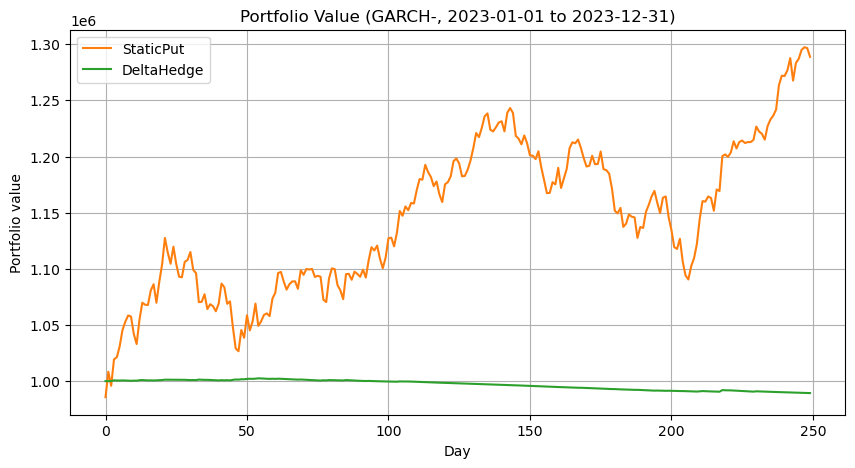

In [11]:
# Plot

days = np.arange(n_steps + 1)
plt.figure(figsize=(10, 5))

plt.plot(days, portfolio_static_put[0], label='StaticPut', color='tab:orange')
plt.plot(days, portfolio_delta_hedged[0], label='DeltaHedge', color='tab:green')

plt.xlabel('Day')
plt.ylabel('Portfolio value')
plt.title(f'Portfolio Value (GARCH-, {start_date} to {end_date})')
plt.legend()
plt.grid(True)

plt.savefig("real.png")
plt.show()

# Interpretation of Results and Plot:

The plot for static put shows that the underlying multi-index portfolio experienced significant positive returns in 2023. It limits downside risk for a known, fixed cost while retaining nearly all of the upside.

The continuous downward slope corresponding to delta hedge represents the accumulated cost of daily rebalancing the portfolio to maintain a delta-neutral position for the long call option.

These strategies are essential in portfolio management because they allow investors to tailor their risk-reward profile by managing volatility and drawdown risk. The core purpose of using these strategies within a Multi-Index Portfolio Simulation is to perform a quantitative risk and performance analysis.

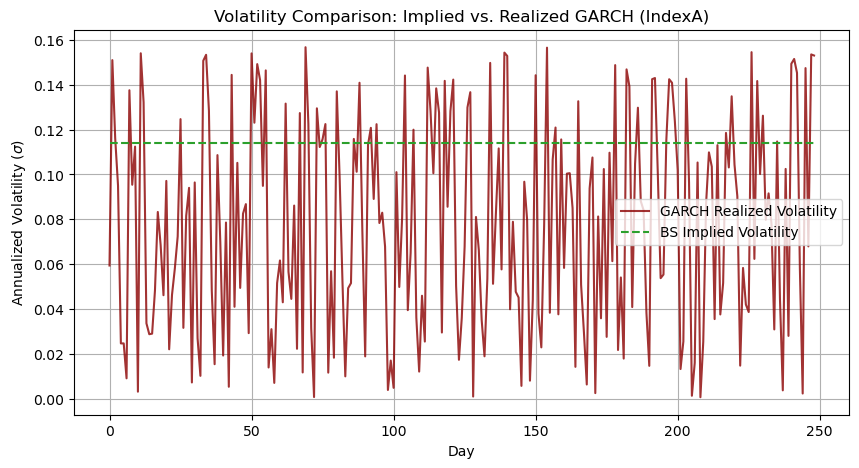

In [12]:
# Realized vs. Implied Volatility

np.random.seed(42)
start_time = time.time()

index_names = ['IndexA', 'IndexB', 'IndexC']
start_date = '2023-01-01'
end_date = '2023-12-31'  

garch_vol_series = {idx: pd.Series(np.random.random(n_steps) * 0.01) for idx in index_names}

# We will use IndexA as an example for plotting
idx_to_plot = 'IndexA'
days_plot = np.arange(n_steps)

# 1. Realized Volatility
# Fetch the conditional vol series and annualize it
realized_garch_vol = garch_vol_series[idx_to_plot].values[:n_steps] * np.sqrt(252.0) 

# 2. Implied Volatility

implied_bs_vol = vol_proxies[idx_to_plot]
implied_vol_path = np.full(n_steps, implied_bs_vol)

plt.figure(figsize=(10, 5))
plt.plot(days_plot, realized_garch_vol, label=f'GARCH Realized Volatility', color='darkred', alpha=0.8)
plt.plot(days_plot, implied_vol_path, label='BS Implied Volatility', color='tab:green', linestyle='--')

plt.title(f'Volatility Comparison: Implied vs. Realized GARCH ({idx_to_plot})')
plt.xlabel('Day')
plt.ylabel('Annualized Volatility ($\sigma$)')
plt.legend()
plt.grid(True)

plt.savefig("real2.png")
plt.show()

# Interpretation

The realized volatility is the actual, time-varying daily volatility estimated by the GARCH(1,1) model for the asset's returns. It represents the true volatility risk the portfolio experienced each day. It fluctuates wildly, displaying volatility clustering and time variation, which are characteristic of real financial markets.